# Packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-21 08:57:33.621696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 08:57:34.331953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import dataset and annotation

In [2]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
# Load h5ad object
adata = anndata.read_h5ad("data/fede_count.h5ad")
# Map appropriate condition tags
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)

# Load cell annotation info
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

In [ ]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = "LD_NC"
adata3 = anndata.read_h5ad("data/C_count.h5ad")
adata3.obs['Sample_Tag'] = "run_5xFAD"
adata4 = anndata.read_h5ad("data/D_count.h5ad")
adata4.obs['Sample_Tag'] = "run_NC"
adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)
adata.obs.index = adata.obs.index.astype('str')

anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])

In [3]:
anno_df = anno_df.set_index('cell_id')[['class_name', "subclass_name", "supertype_name", 'cluster_name']]
adata.obs.index = adata.obs.index.astype(str)
anno_df.index = anno_df.index.astype(str)
adata.obs = adata.obs.merge(anno_df, left_index=True, right_index=True, how='left')

# Data preprocessing

In [4]:
# Initial QC and filtering
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
# Calculate mitochondrial genes percentage
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

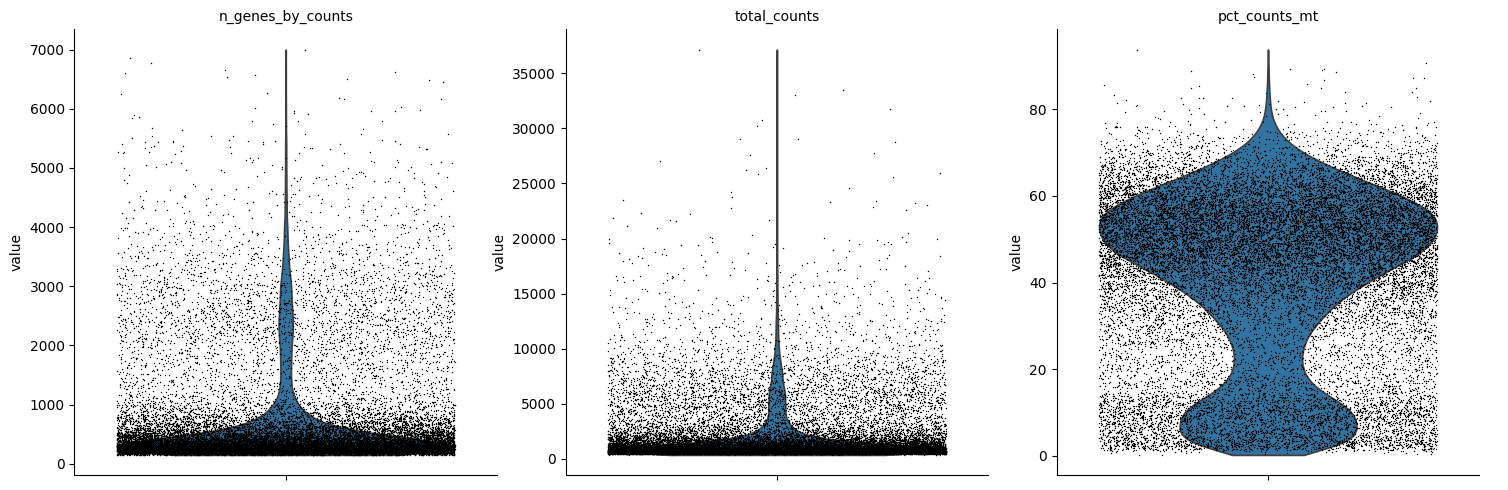

In [6]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

In [7]:
# Filter out cells
adata = adata[~adata.obs['high_mt'], :]
adata = adata[adata.obs['Sample_Name'] != "Multiplet", :]
#adata = adata[:, ~adata.var['mt']]

In [8]:
# Saving raw counts before data transformation
adata.raw = adata

In [9]:
# Preprocess the data: Normalization, log-transformation, and scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=4000, subset=True)
sc.pp.scale(adata)

# Dimensionality reduction

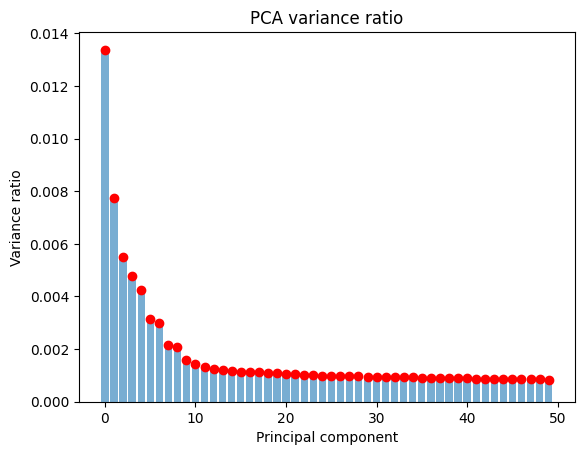

In [10]:
# Plot explained variance vs PCs
elbow_plot(adata)

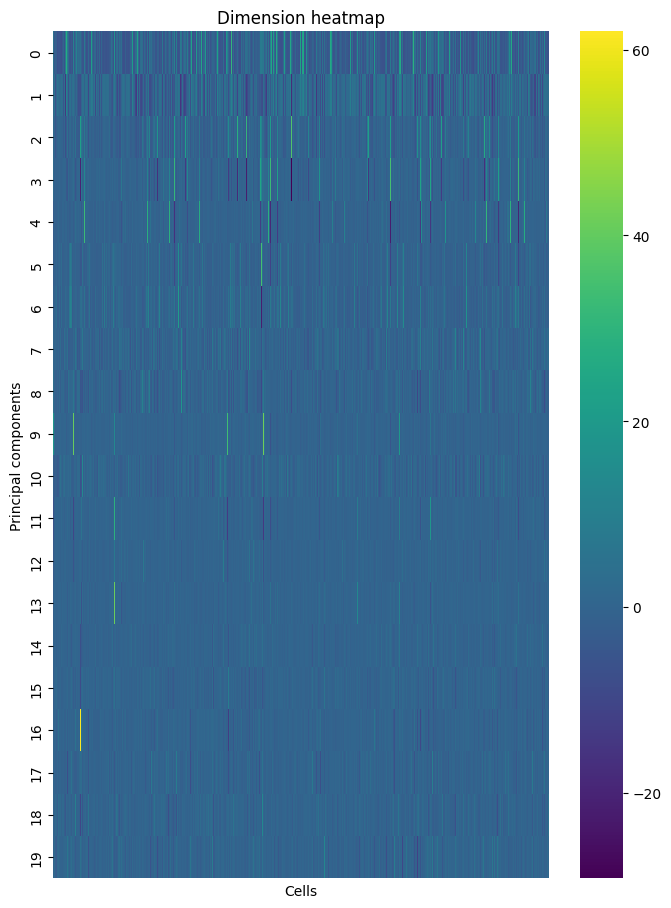

In [11]:
# Dimension heatmap
dimension_heatmap(adata, n_components=20, n_cells=500)

In [12]:
# PCA with optimal n_comps
sc.tl.pca(adata, n_comps=10)

# Batch correction

In [13]:
# Harmony batch correction
harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

2024-06-21 08:58:01,179 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-21 08:58:02,096 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-21 08:58:02,129 - harmonypy - INFO - Iteration 1 of 10
2024-06-21 08:58:03,178 - harmonypy - INFO - Iteration 2 of 10
2024-06-21 08:58:04,246 - harmonypy - INFO - Iteration 3 of 10
2024-06-21 08:58:05,329 - harmonypy - INFO - Iteration 4 of 10
2024-06-21 08:58:06,477 - harmonypy - INFO - Iteration 5 of 10
2024-06-21 08:58:07,671 - harmonypy - INFO - Iteration 6 of 10
2024-06-21 08:58:08,737 - harmonypy - INFO - Converged after 6 iterations


# Clustering

In [14]:
# Neighbors and clustering using Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=10)
sc.tl.leiden(adata, resolution=0.5)

/tmp/ipykernel_4326/2579878520.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


# Visualization

In [15]:
# UMAP
sc.tl.umap(adata)

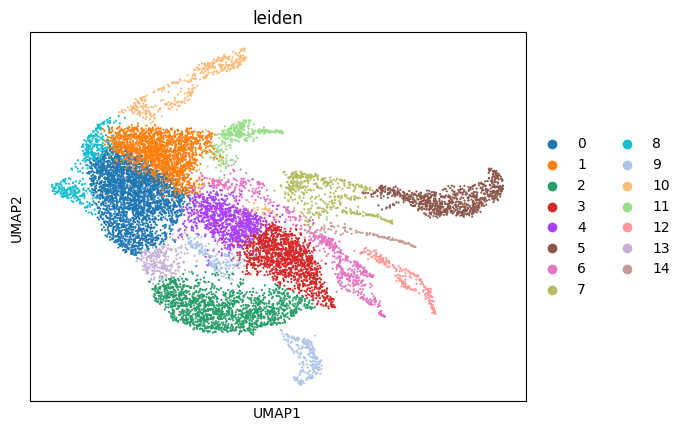

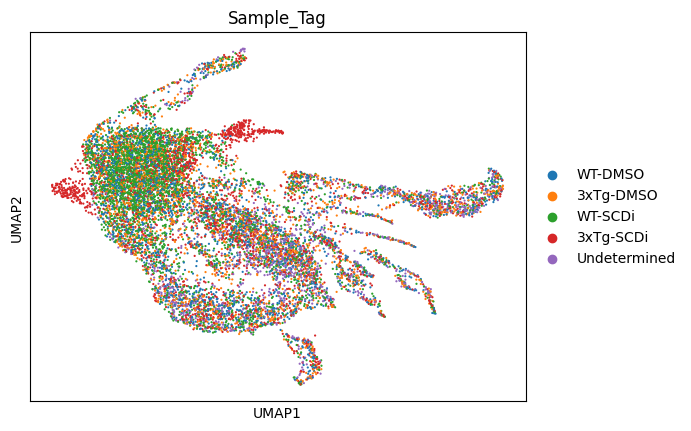

In [16]:
# Plotting
sc.pl.umap(adata, color=['leiden'], save='umap_leiden.png')
sc.pl.umap(adata, color=['Sample_Tag'], save='umap_sampletag.png')
#sc.pl.umap(adata, color=['high_mt'], save='umap_highmt.png')

# Cluster annotation

In [17]:
# Assign unique cell type names to each cluster
assign_unique_cell_type_names(adata, cluster_type='class_name')
assign_unique_cell_type_names(adata, cluster_type='subclass_name')
# Ensure leiden and annotated_cluster are strings for concatenation
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
adata.obs['cluster_class_name'] = adata.obs['cluster_class_name'].astype(str)
adata.obs['cluster_subclass_name'] = adata.obs['cluster_subclass_name'].astype(str)

# Cluster annotation visualization

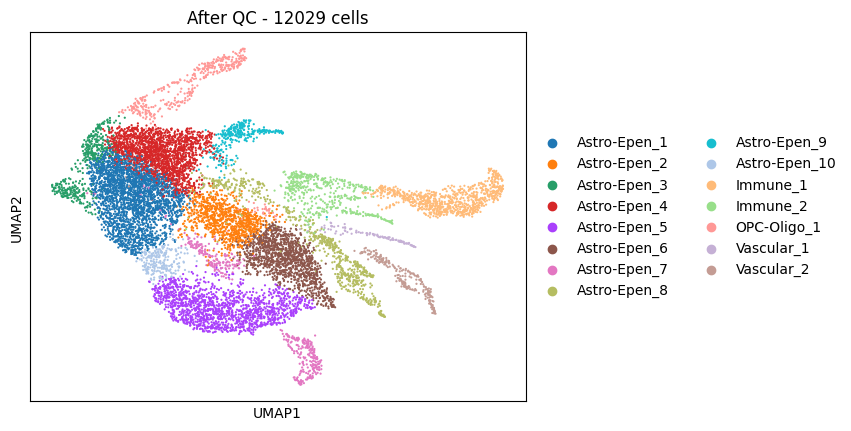

In [21]:
# Plot UMAP with unique cell type annotations
sc.pl.umap(adata, color=['cluster_class_name'], save='umap_all_groups.png', title=f'After QC - {adata.shape[0]} cells', size=10)

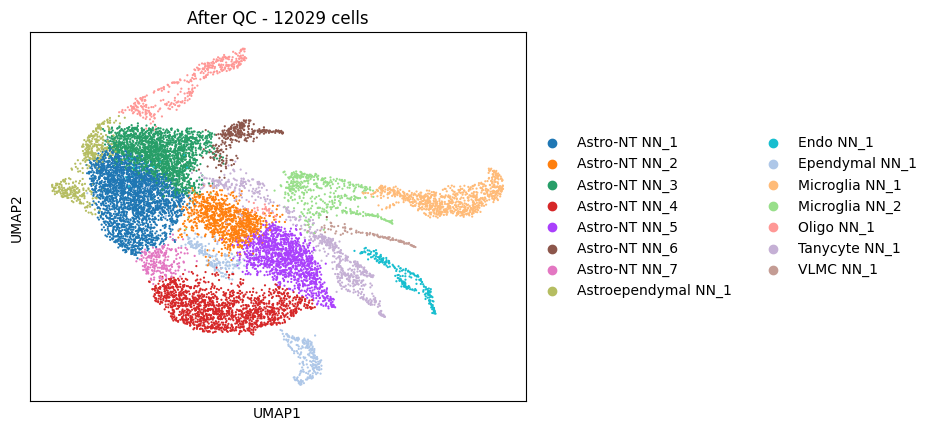

In [22]:
# Plot UMAP with unique cell type annotations
sc.pl.umap(adata, color=['cluster_subclass_name'], save='umap_all_groups.png', title=f'After QC - {adata.shape[0]} cells', size=10)

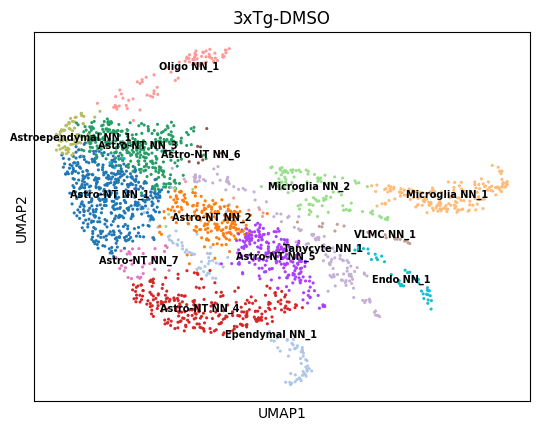

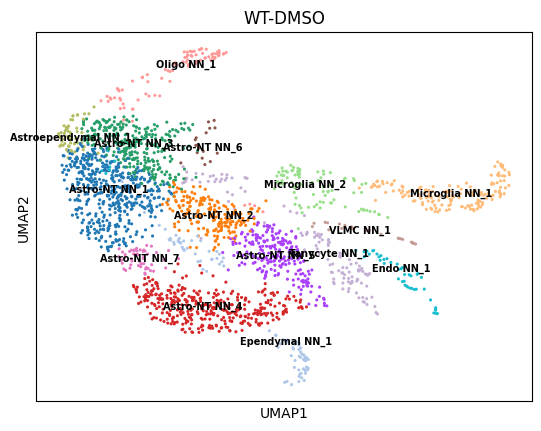

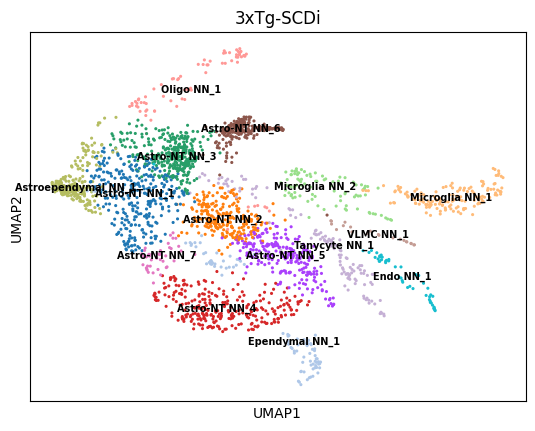

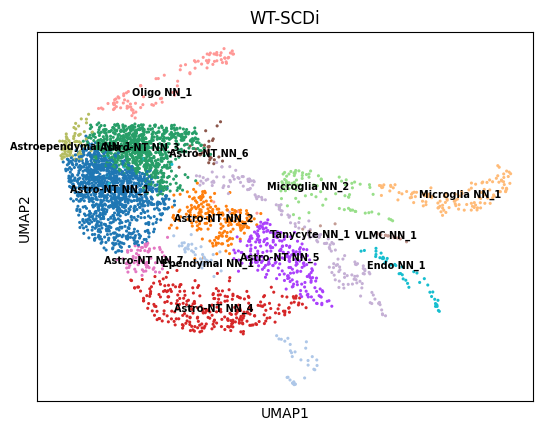

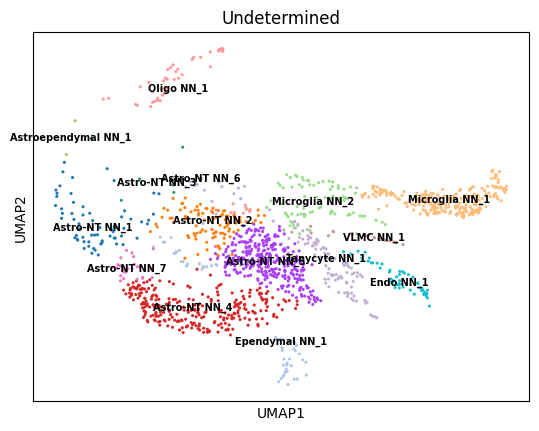

In [23]:
# Plot separately by sample tag
sample_tags = adata.obs['Sample_Tag'].unique()
plot_umap(adata, sample_tags, cluster_type='cluster_subclass_name', legend_fontsize=7)

# Master table

In [27]:
sample_tag_counts = get_master_table(adata, cluster_type='cluster_subclass_name')

/home/client/projects/sc_alz/modules/visualize.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = merged_df.groupby(cluster_type).size().reset_index(name='total_count')
/home/client/projects/sc_alz/modules/visualize.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_tag_counts = merged_df.groupby([cluster_type, 'Sample_Tag']).size().unstack(fill_value=0)


# Clusters composition analysis

In [29]:
class_level, cluster_type = 'class_name', 'cluster_class_name'

/home/client/projects/sc_alz/modules/visualize.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/home/client/projects/sc_alz/modules/visualize.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


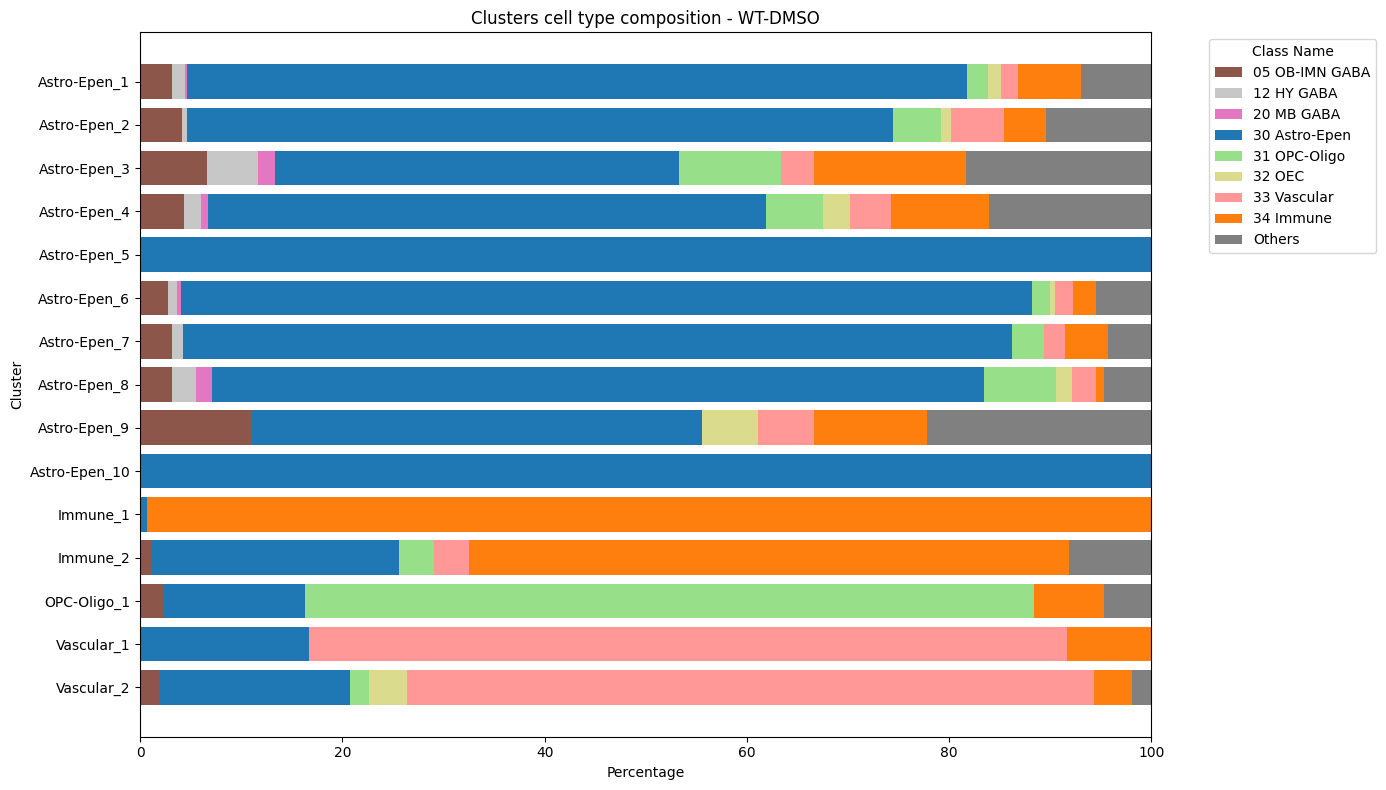

/home/client/projects/sc_alz/modules/visualize.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/home/client/projects/sc_alz/modules/visualize.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


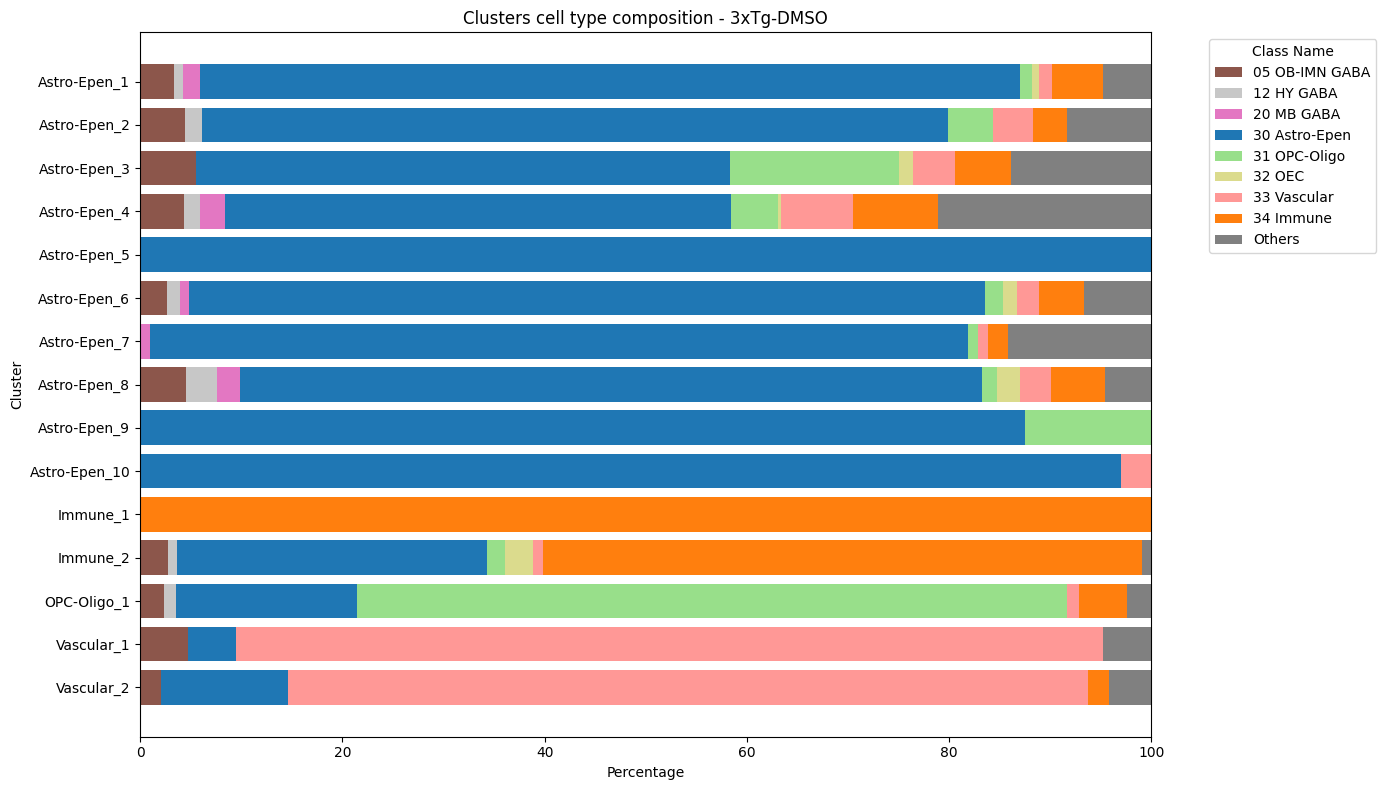

/home/client/projects/sc_alz/modules/visualize.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/home/client/projects/sc_alz/modules/visualize.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


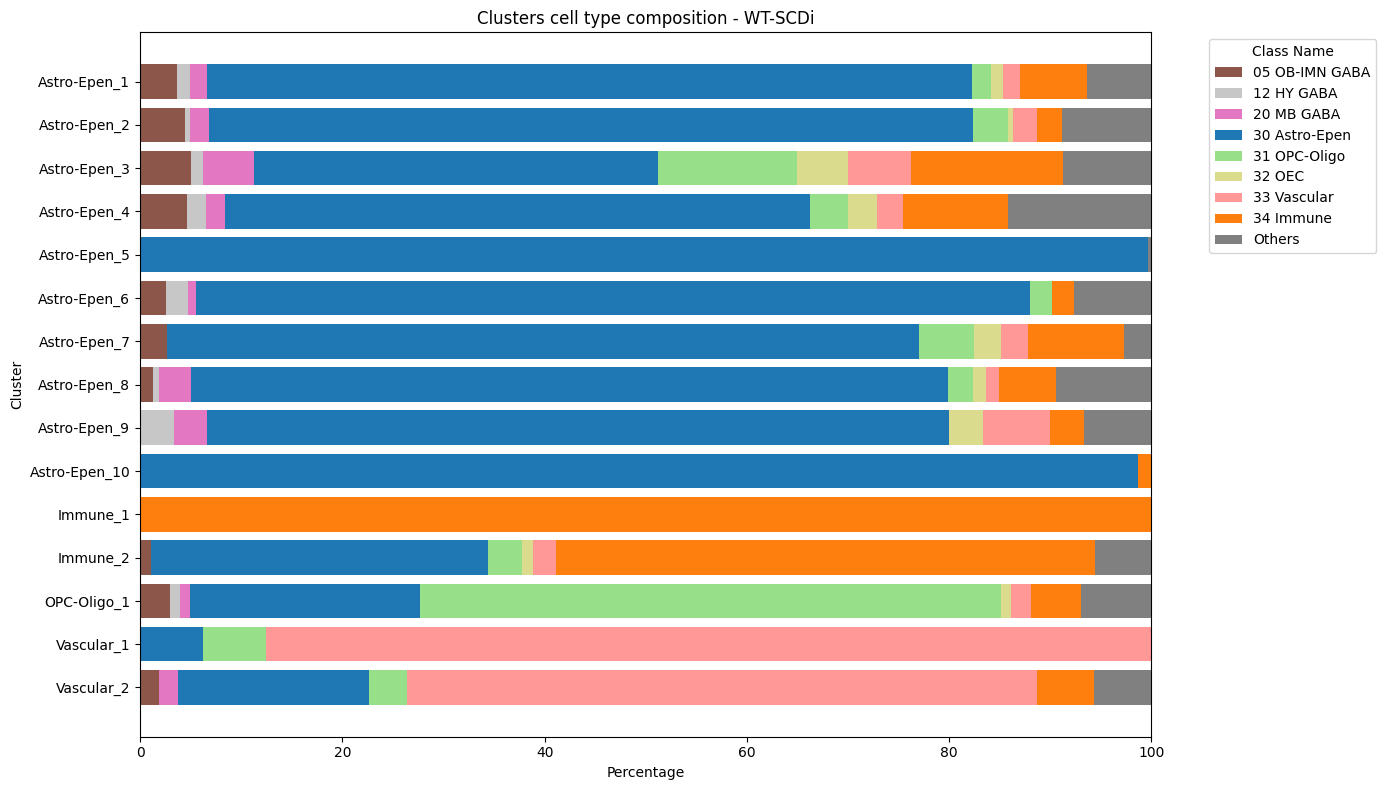

/home/client/projects/sc_alz/modules/visualize.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/home/client/projects/sc_alz/modules/visualize.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


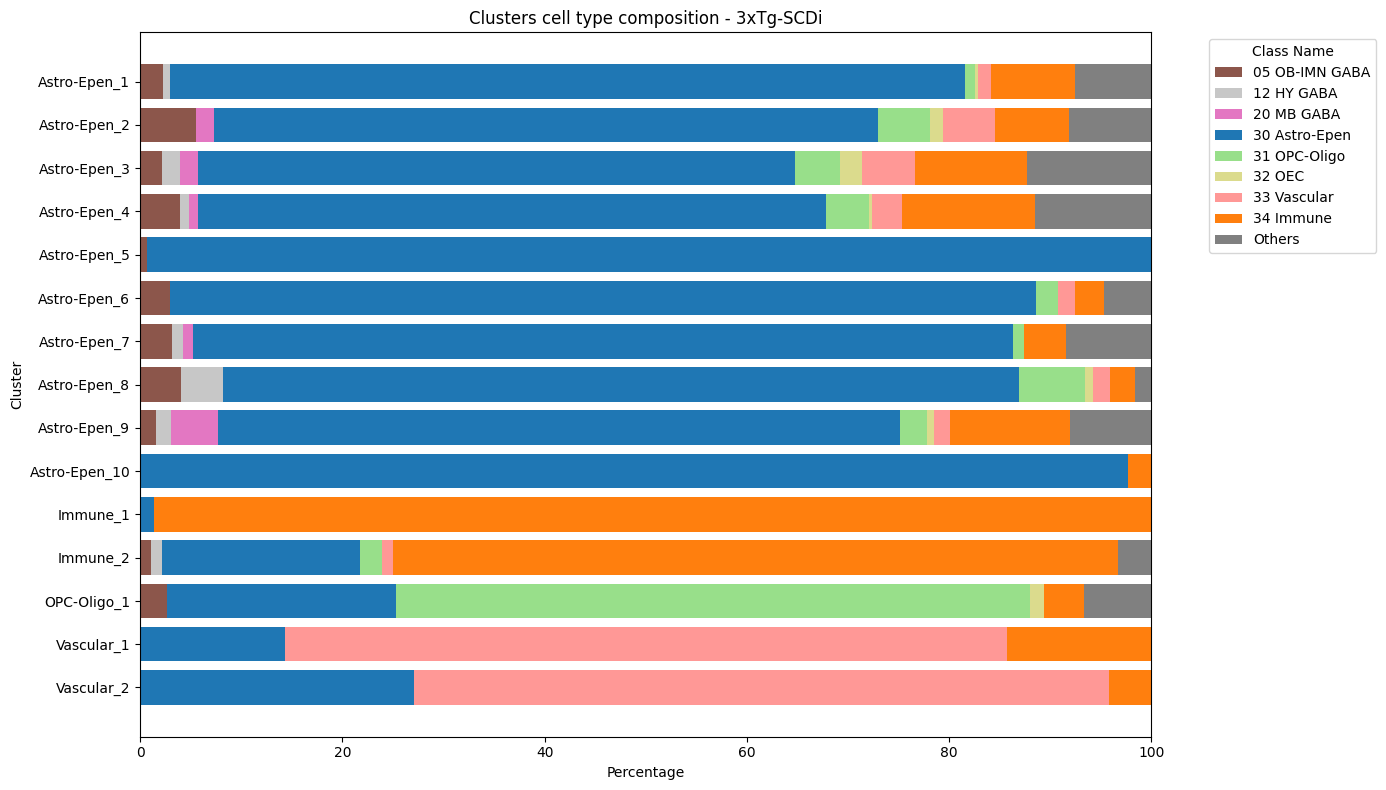

/home/client/projects/sc_alz/modules/visualize.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/home/client/projects/sc_alz/modules/visualize.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


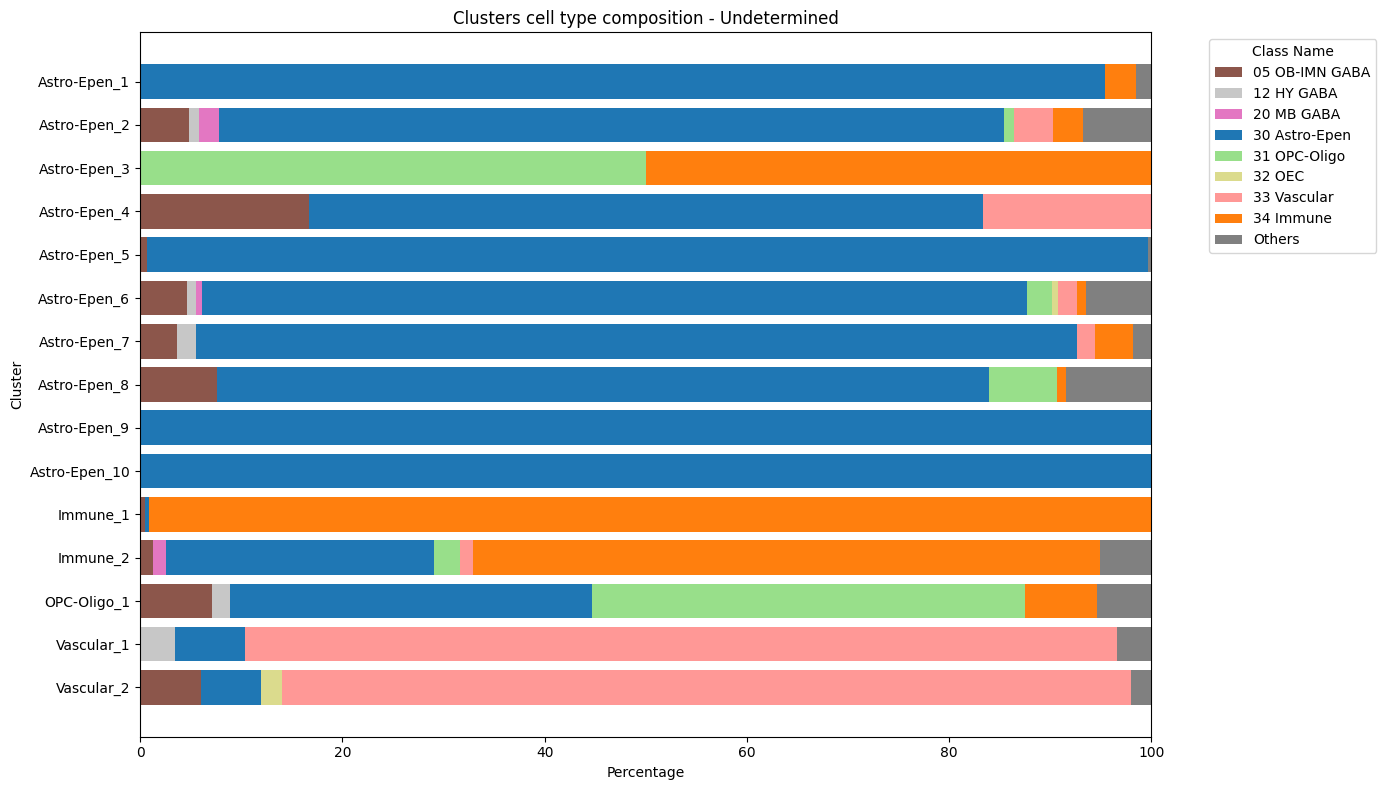

In [30]:
#create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['WT-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['3xTg-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['WT-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['3xTg-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100)

# DEG analysis

In [37]:
cell_types = [x for x in set(adata.obs.cluster_class_name.values)]

In [ ]:
#Select conditions to analyze

#ctr, cnd = 'WT-DMSO', '3xTg-DMSO'
#ctr, cnd = 'WT-DMSO', 'WT-SCDi'
#ctr, cnd = 'WT-DMSO', '3xTg-SCDi'
#ctr, cnd = '3xTg-DMSO', '3xTg-SCDi'

In [ ]:
ctr, cnd = 'WT-DMSO', 'WT-SCDi'

cluster_n_DEGs = []
min_fold_change = 0.25
max_p_value = 0.05
for cell_type in tqdm(cell_types):
    df = DEG_analysis_deseq2(adata, ctr, cnd, [cell_type])
    if df is None:
        continue
    positive_enriched = df[(df['log2FoldChange'] > min_fold_change) & (df['padj'] < max_p_value)]
    negative_enriched = df[(df['log2FoldChange'] < -min_fold_change) & (df['padj'] < max_p_value)]
    positive_count = positive_enriched.shape[0]
    negative_count = negative_enriched.shape[0]
    cluster_n_DEGs.append((cell_type, positive_count, negative_count))

horizontal_deg_chart(cluster_n_DEGs, 'wt_dmso_vs_wt_scdi')

In [ ]:
ctr, cnd = 'WT-DMSO', '3xTg-DMSO'

cluster_n_DEGs = []
min_fold_change = 0.25
max_p_value = 0.05
for cell_type in tqdm(cell_types):
    df = DEG_analysis_deseq2(adata, ctr, cnd, [cell_type])
    if df is None:
        continue
    positive_enriched = df[(df['log2FoldChange'] > min_fold_change) & (df['padj'] < max_p_value)]
    negative_enriched = df[(df['log2FoldChange'] < -min_fold_change) & (df['padj'] < max_p_value)]
    positive_count = positive_enriched.shape[0]
    negative_count = negative_enriched.shape[0]
    cluster_n_DEGs.append((cell_type, positive_count, negative_count))

horizontal_deg_chart(cluster_n_DEGs, 'wt_dmso_vs_3xtg_dmso')

In [ ]:
ctr, cnd = 'WT-DMSO', '3xTg-SCDi'

cluster_n_DEGs = []
min_fold_change = 0.25
max_p_value = 0.05
for cell_type in tqdm(cell_types):
    df = DEG_analysis_deseq2(adata, ctr, cnd, [cell_type])
    if df is None:
        continue
    positive_enriched = df[(df['log2FoldChange'] > min_fold_change) & (df['padj'] < max_p_value)]
    negative_enriched = df[(df['log2FoldChange'] < -min_fold_change) & (df['padj'] < max_p_value)]
    positive_count = positive_enriched.shape[0]
    negative_count = negative_enriched.shape[0]
    cluster_n_DEGs.append((cell_type, positive_count, negative_count))

horizontal_deg_chart(cluster_n_DEGs, 'wt_dmso_vs_3xtg_scdi')

In [ ]:
ctr, cnd = '3xTg-DMSO', '3xTg-SCDi'

cluster_n_DEGs = []
min_fold_change = 0.25
max_p_value = 0.05
for cell_type in tqdm(cell_types):
    df = DEG_analysis_deseq2(adata, ctr, cnd, [cell_type])
    if df is None:
        continue
    positive_enriched = df[(df['log2FoldChange'] > min_fold_change) & (df['padj'] < max_p_value)]
    negative_enriched = df[(df['log2FoldChange'] < -min_fold_change) & (df['padj'] < max_p_value)]
    positive_count = positive_enriched.shape[0]
    negative_count = negative_enriched.shape[0]
    cluster_n_DEGs.append((cell_type, positive_count, negative_count))

horizontal_deg_chart(cluster_n_DEGs, '3xtg_dmso_vs_3xtg_scdi')

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

R[write to console]: Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.0 (2024-04-24)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2' 



Counts shape: (5880, 25244)
Metadata shape: (5880, 1)


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regressio

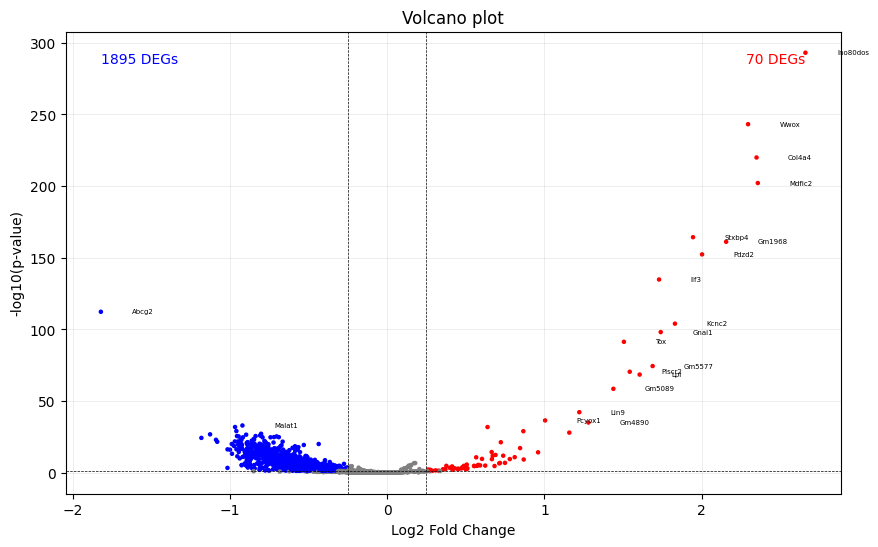

In [40]:
ctr, cnd = 'WT-DMSO', 'WT-SCDi'
results_df1 = DEG_analysis_deseq2(adata, ctr, cnd, cell_types)
get_volcano_plot(results_df1, 'wt_dmso_vs_wt_scdi', min_fold_change=0.25, max_p_value=0.05)

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

R[write to console]: Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.0 (2024-04-24)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2' 



Counts shape: (4535, 25244)
Metadata shape: (4535, 1)


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regressio

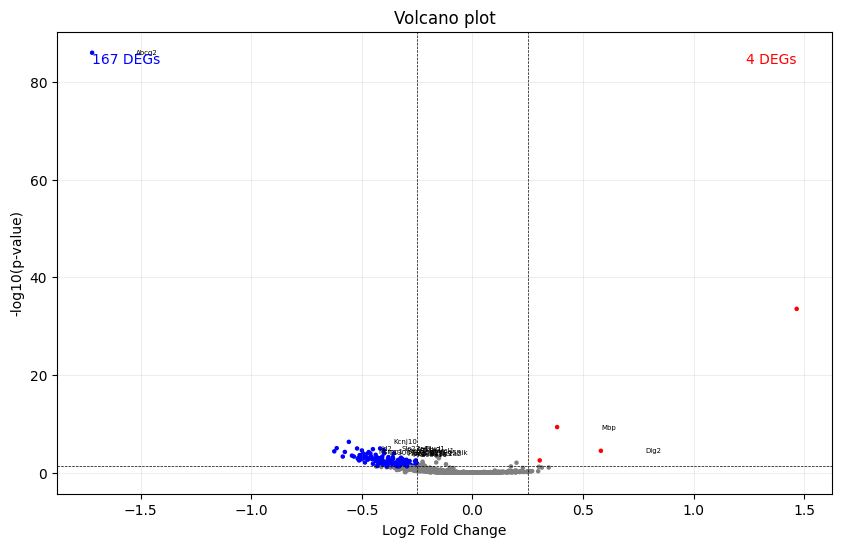

In [41]:
ctr, cnd = 'WT-DMSO', '3xTg-DMSO'
results_df2 = DEG_analysis_deseq2(adata, ctr, cnd, cell_types)
get_volcano_plot(results_df2, 'wt_dmso_vs_3xtg_dmso', min_fold_change=0.25, max_p_value=0.05)

In [ ]:
ctr, cnd = 'WT-DMSO', '3xTg-SCDi'
results_df3 = DEG_analysis_deseq2(adata, ctr, cnd, cell_types)
get_volcano_plot(results_df3, 'wt_dmso_vs_3xtg_scdi', min_fold_change=0.25, max_p_value=0.05)

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

R[write to console]: Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.0 (2024-04-24)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2' 



Counts shape: (4810, 25244)
Metadata shape: (4810, 1)


In [ ]:
ctr, cnd = '3xTg-DMSO', '3xTg-SCDi'
results_df4 = DEG_analysis_deseq2(adata, ctr, cnd, cell_types)
get_volcano_plot(results_df4, '3xtg_dmso_vs_3xtg_scdi', min_fold_change=0.25, max_p_value=0.05)

# GO term enrichment analysis

In [ ]:
pos_DEGs = [index for index, x in results_df.T.to_dict().items() if x['log2FoldChange'] > 0.25 and x['padj'] < 0.05]
neg_DEGs = [index for index, x in results_df.T.to_dict().items() if x['log2FoldChange'] < -0.25 and x['padj'] < 0.05]

In [ ]:
genes_ncbi = query_genes(adata.raw)

In [ ]:
pos_gene_ids = [int(genes_ncbi[x.upper()]) for x in pos_DEGs if x.upper() in genes_ncbi.keys()]
neg_gene_ids = [int(genes_ncbi[x.upper()]) for x in neg_DEGs if x.upper() in genes_ncbi.keys()]

In [ ]:
pos_go_results = perform_go_enrichment(pos_gene_ids, [int(x) for x in genes_ncbi.values()])
neg_go_results = perform_go_enrichment(neg_gene_ids, [int(x) for x in genes_ncbi.values()])

In [ ]:
#BP, MF or CC
display_go_enrichment(pos_go_results, 'pos_DEG_wt_dmso_vs_3xtg_scdi_astroepen6', namespace='BP')

In [ ]:
#BP, MF or CC
display_go_enrichment(neg_go_results, 'neg_DEG_wt_dmso_vs_3xtg_scdi_astroepen6', namespace='BP')

In [ ]:
#import pickle
#DEGs_wt_dmso_vs_3xtg_scdi = (pos_DEGs, neg_DEGs)
#with open('DEGs_wt_dmso_vs_3xtg_scdi.pkl', 'wb') as f:
#    pickle.dump(DEGs_wt_dmso_vs_3xtg_scdi, f)
#with open('DEGs_wt_dmso_vs_3xtg_scdi.pkl', 'rb') as f:
#    DEGs_wt_dmso_vs_3xtg_scdi = pickle.load(f)
#with open('DEGs_wt_dmso_vs_3xtg_dmso.pkl', 'rb') as f:
#    DEGs_wt_dmso_vs_3xtg_dmso = pickle.load(f)